# Classification of Players

This notebook process the game history data to calculate key metrics on players based on their betting history.  This information will be used to group the players using k-means.


In [2]:
import pandas as pd
import numpy as np

StatementMeta(sparkpool, 3, 3, Finished, Available)

## Create a dataframe

We need get the data in a pandas dataframe for some manipulation and for building an ML classicification process.  We care about the total player activity across all their games.   In order to make this as efficent as possible we're going to use the playergamesummary table.  This table gives us the attributes we care about by player, game, and date, we need to aggregate these values by player.

In [3]:
#Remove player Player00008. This player shows up in all the games, but doesn't ever bet or raise so we need to exclude it.
df = spark.sql("SELECT  player, SUM(vpipCt) as VPIP_Ct, SUM(pfrCt) as PFR_Ct, SUM(gameCt) as Game_Ct, SUM(profit) as Winnings, (SUM(profit)/SUM(gameCt))*100 as WinningsPer100 FROM pokerdata.playergamesummary where player <> 'Player00008' GROUP BY player").toPandas()

StatementMeta(sparkpool, 3, 4, Finished, Available)

# Feature engineering

Off of the counts exposed in the views, we need to convert these values to ratios for the model.  We also need to deal with some nulls in the data.

The values we calculate are:

1. PFR - Pre Flop Raise - how often does a player raise before the flop.
1. VP$IP - Voluntarily put money in the pot - how often does a player play a hand.  In this case lower indicates a shrewd player, not playing all hands but strategically waiting playable hands.
1. pfr_rate - Rate of PFR to VPIP - when a player is playing the hand, how aggressively are they playing the hand.

In [4]:
# Manufacture new columns in the dataset

#PFR -> How often does the player raise before the flop
df['PFR'] = df['PFR_Ct']/df['Game_Ct']
#VP$P -> How often does the player voluntarily put money in the pot (ie. bet, call, raise, but not blind)
df['VP$IP'] = df['VPIP_Ct']/df['Game_Ct']
#pfr_rate -> When a player is betting on a game how often is it a pre flop raise.  This is a measure of aggression.
df['pfr_rate'] = df['PFR'] / df['VP$IP']
df['playertype'] = ''
df['labels'] = -1
# Fill in blanks
df['pfr_rate'] = df['pfr_rate'].fillna(0)

StatementMeta(sparkpool, 3, 5, Finished, Available)

## Split the dataset

In order for the statistics to hold true we need a certain volume of games to accurately assess a player.  By excluding outliers we can get a more pure representation of the clusers of player tyeps.

For this scenario we need players that actually have beeting history and have played at least 500 games.

In [5]:
#split out the veteran players from the noobs
df_vets = df[(df['Game_Ct'] >= 500) & (df['PFR_Ct'] > 0) & (df['VPIP_Ct'] > 0)]
df_vets['playertype'] = 'vet'
df_noobs = df[(df['Game_Ct'] < 500) | (df['PFR_Ct'] == 0) | (df['VPIP_Ct'] == 0)]
df_noobs['playertype'] = 'noob'

StatementMeta(sparkpool, 3, 6, Finished, Available)

/mnt/var/hadoop/tmp/nm-local-dir/usercache/trusted-service-user/appcache/application_1613582614008_0004/container_1613582614008_0004_01_000001/tmp/6144509923836744749:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # contributor license agreements.  See the NOTICE file distributed with
/mnt/var/hadoop/tmp/nm-local-dir/usercache/trusted-service-user/appcache/application_1613582614008_0004/container_1613582614008_0004_01_000001/tmp/6144509923836744749:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # The ASF 

In [6]:
print(df_vets.head())
print(df_noobs.head())

StatementMeta(sparkpool, 3, 7, Finished, Available)

         player  VPIP_Ct  PFR_Ct  ...  pfr_rate  playertype  labels
0  Player000461     4544    1659  ...  0.365097         vet      -1
1  Player001163      282     104  ...  0.368794         vet      -1
2  Player001694      752      55  ...  0.073138         vet      -1
5  Player002506      289     132  ...  0.456747         vet      -1
7  Player003311      279      76  ...  0.272401         vet      -1

[5 rows x 11 columns]
          player  VPIP_Ct  PFR_Ct  ...  pfr_rate  playertype  labels
3   Player001787       97      42  ...  0.432990        noob      -1
4   Player002464      107      50  ...  0.467290        noob      -1
6   Player003232      116      31  ...  0.267241        noob      -1
14  Player006707       63       9  ...  0.142857        noob      -1
15  Player006774       61      16  ...  0.262295        noob      -1

[5 rows x 11 columns]

## Prep dataframe for ML

For this scenario we're going to be leveraging k-means to identify clusters of players based on their betting attributes.  The hypothesis here is that certain playing styles are more successful than others, so we'll cluster the players and later compare the clusters to winngs.  For our model, we'll be focusing on pfr_rate and vp$ip.

In [7]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

#Limit attributes for K-Means clustering
attributes = ['pfr_rate','VP$IP']

# Create DataFrame for K Means Model
x = df_vets[attributes]

StatementMeta(sparkpool, 3, 8, Finished, Available)

## Examine number of clusters

In order to determine the optimal number of clusters in our model, we need to evaluate the distortion of the model to see when adding new clusers no longer yields a benefit.  In this step we'll iterate from 1-10 clusters and graph the distortion measurement.

The graph below shows the "elbow" in the chart between 3 - 4, so we'll leverage 4 clusters for our k-means implementation.



StatementMeta(sparkpool, 3, 9, Finished, Available)

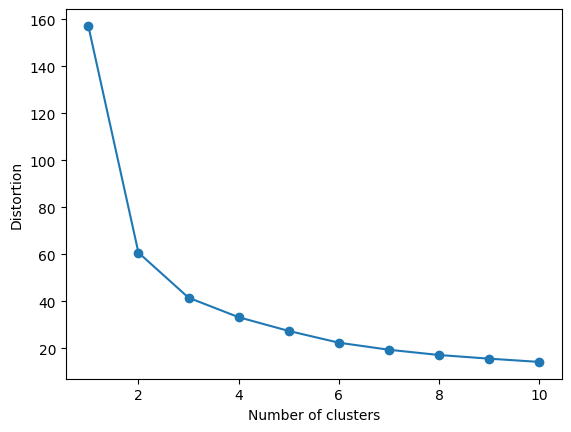

In [8]:
#Measure distortion to see the optimal number of logical clusters in the data
import matplotlib.pyplot as plt

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(x)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## Build k-means model

Using scikit learn we initialize the model with 4 clusters, and fit the model based on the data from our "veteran" players.

In this example we output the centers of the clusters, and also apply the predicted clusters for each veteran player to the dataframe.

In [9]:
# Use k-means to identify loose-passive, loose-aggressive, tight-passive, and tight-aggressive clusters
from sklearn.cluster import KMeans

# Create and fit the K Means Model, and label the vets records
kmeans_model = KMeans(n_clusters=4, n_init=10, tol=1e-04, random_state=235235)
labels = kmeans_model.fit_predict(x)

centers = kmeans_model.cluster_centers_
print(centers)

#add the labels into the vets dataframe
df_vets['labels'] = labels
print(df_vets['labels'].unique())
print(df_vets.head())

StatementMeta(sparkpool, 3, 10, Finished, Available)

[[0.49308526 0.2714702 ]
 [0.69833886 0.1882861 ]
 [0.18963477 0.47251761]
 [0.2156957  0.25628542]]
[0 3 2 1]
         player  VPIP_Ct  PFR_Ct  ...  pfr_rate  playertype  labels
0  Player000461     4544    1659  ...  0.365097         vet       0
1  Player001163      282     104  ...  0.368794         vet       0
2  Player001694      752      55  ...  0.073138         vet       3
5  Player002506      289     132  ...  0.456747         vet       0
7  Player003311      279      76  ...  0.272401         vet       3

[5 rows x 11 columns]
/mnt/var/hadoop/tmp/nm-local-dir/usercache/trusted-service-user/appcache/application_1613582614008_0004/container_1613582614008_0004_01_000001/tmp/6144509923836744749:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Apply model to Newbie players

Since we identified the cluster centroids with the veteran players, we want to use that same logics with the Noob players.  Here we extract the same attributes from the noobs dataframe and predict the classes for the noob players as well with kmeans_model.predict()

In [10]:
#Get the two attributes from the noobs dataframe and predict
y = df_noobs[attributes] 
labels = kmeans_model.predict(y)

#add the labels into the noobs dataframe
df_noobs['labels'] = labels
print(df_noobs['labels'].unique())
print(df_noobs.head())

StatementMeta(sparkpool, 3, 11, Finished, Available)

[0 3 2 1]
          player  VPIP_Ct  PFR_Ct  ...  pfr_rate  playertype  labels
3   Player001787       97      42  ...  0.432990        noob       0
4   Player002464      107      50  ...  0.467290        noob       0
6   Player003232      116      31  ...  0.267241        noob       3
14  Player006707       63       9  ...  0.142857        noob       2
15  Player006774       61      16  ...  0.262295        noob       3

[5 rows x 11 columns]
/mnt/var/hadoop/tmp/nm-local-dir/usercache/trusted-service-user/appcache/application_1613582614008_0004/container_1613582614008_0004_01_000001/tmp/6144509923836744749:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # (the "License"); you may not use this file except in compliance with

## Manipulate the dataframe

Now that we've classified both the veteran and noob players, we need to do some manipulaton of the data for both analysis/charting and also persistence.

We do the following:

1. Merge the two dataframes.
1. Split the merged dataframes by category for pyplot purposes
1. Print some general statistics on each category
1. Chart the clusters using pyplot and output the centroids

In [11]:
#To visualize noobs instead, change this line.
df_results = df_vets

# Create DataFrames for each cluster.  This helps with charting
df_0 = df_results[df_results['labels'] == 0]
df_1 = df_results[df_results['labels'] == 1]
df_2 = df_results[df_results['labels'] == 2]
df_3 = df_results[df_results['labels'] == 3]

#Print reminder notes about how we're evaluating
print('Calling Station =  low pfr_rate and high VP$IP')
print('Tight Aggressive = high pfr_rate and low VP$IP')
print('Rock = low pfr_rate and low VP$IP')
print('Loose Aggressive = high pfr_rate and high VP$IP')
print()

#Print count of data points and mean of attributes in each cluster (centroids)
print(len(df_0[attributes]))
print(df_0[attributes].mean())
print('Average winnings: {}, Total winnings: {}'.format((df_0['Winnings'].sum()/df_0["Game_Ct"].sum())*100,df_0['Winnings'].sum()))
print()
print(len(df_1[attributes]))
print(df_1[attributes].mean())
print('Average winnings: {}, Total winnings: {}'.format((df_1['Winnings'].sum()/df_1["Game_Ct"].sum())*100,df_1['Winnings'].sum()))
print()
print(len(df_2[attributes]))
print(df_2[attributes].mean())
print('Average winnings: {}, Total winnings: {}'.format((df_2['Winnings'].sum()/df_2["Game_Ct"].sum())*100,df_2['Winnings'].sum()))
print()
print(len(df_3[attributes]))
print(df_3[attributes].mean())
print('Average winnings: {}, Total winnings: {}'.format((df_3['Winnings'].sum()/df_2["Game_Ct"].sum())*100,df_3['Winnings'].sum()))
print()


StatementMeta(sparkpool, 3, 12, Finished, Available)

Calling Station =  low pfr_rate and high VP$IP
Tight Aggressive = high pfr_rate and low VP$IP
Rock = low pfr_rate and low VP$IP
Loose Aggressive = high pfr_rate and high VP$IP

864
pfr_rate    0.492835
VP$IP       0.271732
dtype: float64
Average winnings: -0.9199737853810239, Total winnings: -17775.742680869997

865
pfr_rate    0.698189
VP$IP       0.188256
dtype: float64
Average winnings: 0.09956276168233114, Total winnings: 3727.6666356083006

339
pfr_rate    0.189580
VP$IP       0.473467
dtype: float64
Average winnings: -3.9588289220540718, Total winnings: -15514.610957240686

492
pfr_rate    0.215297
VP$IP       0.256682
dtype: float64
Average winnings: -2.584311591233263, Total winnings: -10127.891282927245

StatementMeta(sparkpool, 3, 13, Finished, Available)

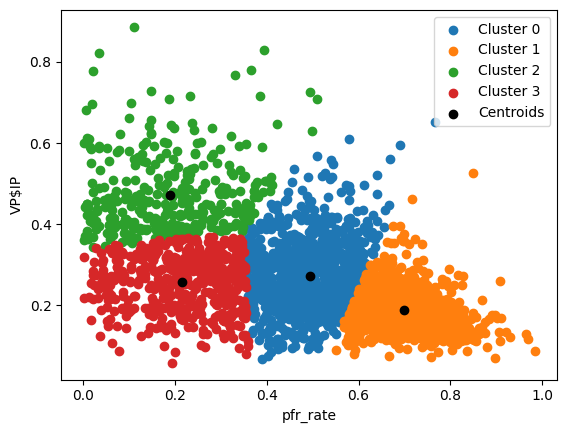

In [12]:

#Build a plot showing the datapoints and centroids of the identified clusters
fig = plt.figure()
ax = fig.add_subplot()
#Plot the labeled data as a scater of vpip and aggression
scatter = ax.scatter(df_0['pfr_rate'],df_0['VP$IP'], c='C0', label="Cluster 0")
scatter = ax.scatter(df_1['pfr_rate'],df_1['VP$IP'], c='C1', label="Cluster 1")
scatter = ax.scatter(df_2['pfr_rate'],df_2['VP$IP'], c='C2', label="Cluster 2")
scatter = ax.scatter(df_3['pfr_rate'],df_3['VP$IP'], c='C3', label="Cluster 3")


scatter = ax.scatter(centers[:,0], centers[:,1], c='black', label="Centroids")
ax.set_xlabel('pfr_rate')
ax.set_ylabel('VP$IP')
ax.legend()
plt.show()

## Persist the dataframe

Convert the pandas dataframe to spark, then save it as table to spark, which will create the underlying parquet structure.

In [13]:
#Merge the data frames before persisting the results
df_allplayers = df_vets.append(df_noobs)


StatementMeta(sparkpool, 3, 14, Finished, Available)

In [15]:
#Convert the dataframe from pandas -> spark.
df_output = spark.createDataFrame(df_allplayers)

#Output the data frame as a spark table.   We expect to run this often so overwrite whatever is there.
df_output.write.mode('overwrite').saveAsTable('pokerdata.playersummary')

StatementMeta(sparkpool, 3, 16, Finished, Available)